## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Here I will calibrate the camera and save the calibration

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort the image and save both original and undistorted images to output_images
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/Undistorted_Image.jpg',dst)
cv2.imwrite('output_images/Original_Image.jpg',img)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)
## A distortion-corrected test image.
I used the calibration from the above cells to undistort this test image:

In [4]:
# Load a test image
img = cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points (From above)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   img_size, 
                                                   cameraMatrix = None, 
                                                   distCoeffs = None)

# Undistort the image and save both original and undistorted images to output_images
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the images for the output.
cv2.imwrite('output_images/Undistorted_Test_Image.jpg',dst)
cv2.imwrite('output_images/Original_Test_Image.jpg',img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply a distortion correction to raw images.

In [5]:
# Load calibration parameters
calibration = pickle.load(open( "camera_cal/calibration.p", "rb"))
mtx = calibration["mtx"]
dist = calibration["dist"]

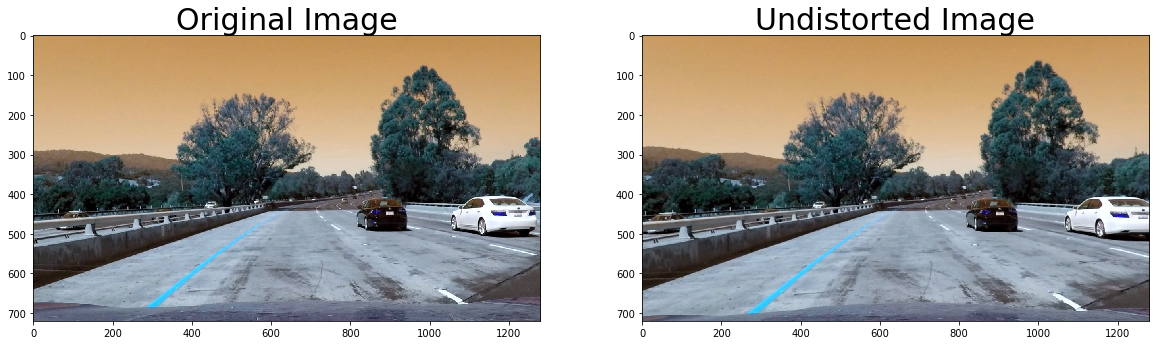

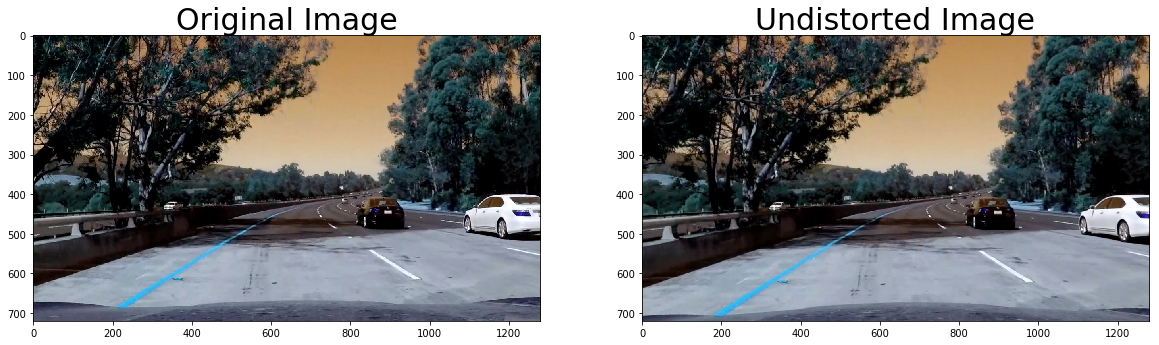

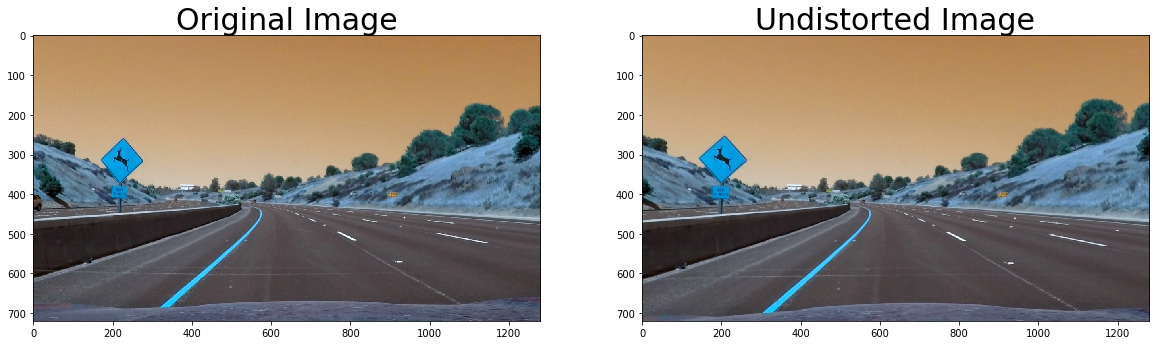

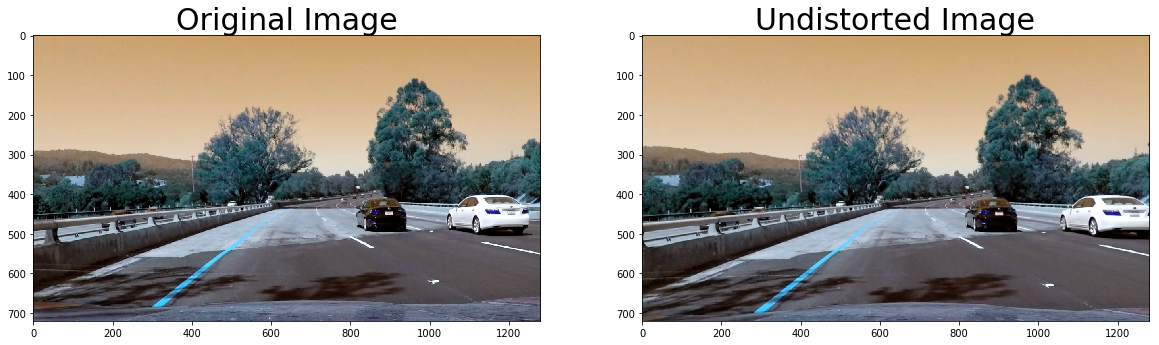

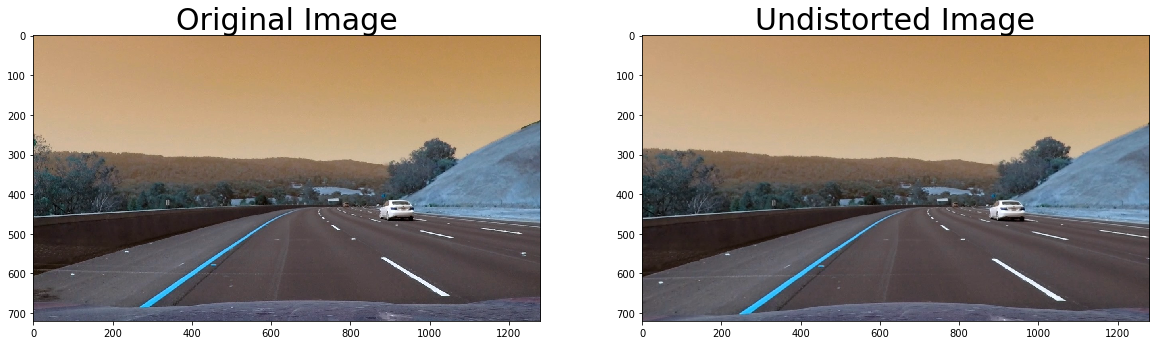

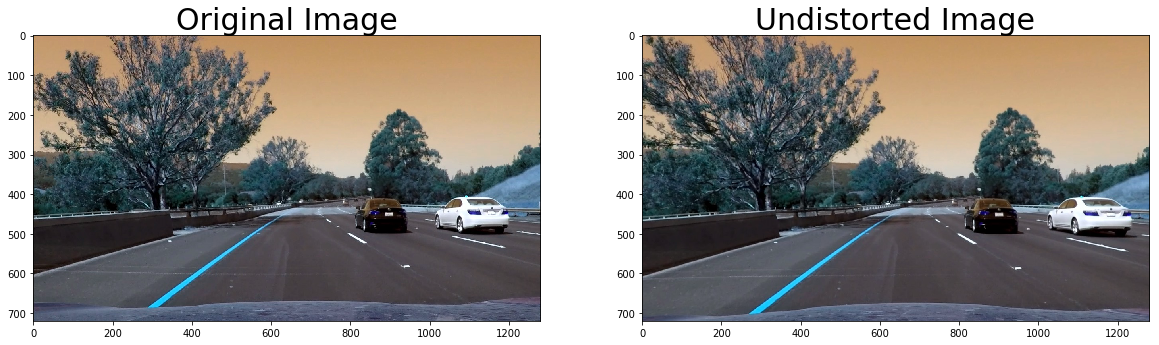

In [6]:
%matplotlib inline
# Make a list of test images
images = glob.glob('test_images/test*.jpg')

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

## Applying thresholds to produce binary image

Use color transforms, gradients, etc., to create a thresholded binary image.

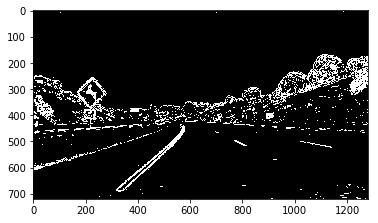

True

In [7]:
from binarythresholding import *

image = cv2.imread('./test_images/test2.jpg')
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def produce_thresholded_binary(image, ksize = 3):

    # Extract the Saturation channel
    s_channel = hls_select(image)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(15, 255))
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, thresh=(20, 120))

    combined = np.zeros_like(mag_binary)
    combined[(gradx == 1) | (grady == 1) | (mag_binary == 1)] = 1
    
    scaled_combination = np.uint8(255*combined)
    
    return scaled_combination

scaled_combination = produce_thresholded_binary(image)

plt.imshow(scaled_combination, cmap='gray')
plt.show()

# Save the images to output_images for the writeup
cv2.imwrite('output_images/binary_result.jpg', scaled_combination)
cv2.imwrite('output_images/before_binary.jpg', image)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
# This code was included in examples/example.py
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

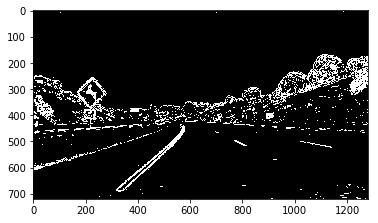

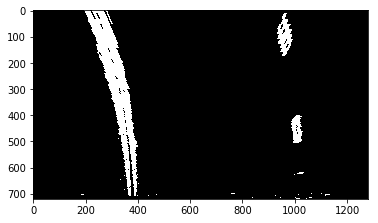

True

In [9]:
def perspective_transform(image):

    img_size = (image.shape[1], image.shape[0])

    # These points were given in the markup tutorial.
    # src is a trapezoid that overlays the lane on the original image.
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # dst is a rectangle that has the same shape and orientation of the image itself.
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    binary_warped = warper(image, src, dst)
    
    return (binary_warped, src, dst)

binary_warped, src, dst = perspective_transform(scaled_combination)

plt.imshow(scaled_combination, cmap='gray')
plt.show()
plt.figure()
plt.imshow(binary_warped, cmap='gray')
plt.show()

# Save the images to output_images for the writeup
cv2.imwrite('output_images/perspective_result.jpg', binary_warped)
cv2.imwrite('output_images/perspective_original.jpg', scaled_combination)

## Detect lane pixels and fit to find the lane boundary.

/home/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


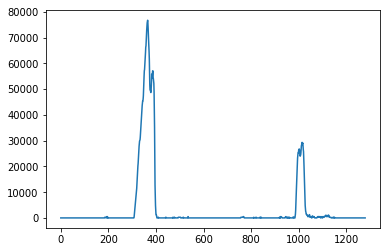

In [10]:
%matplotlib inline
# Plotting a histogram to detect the x location of the lane lines.
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

/home/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


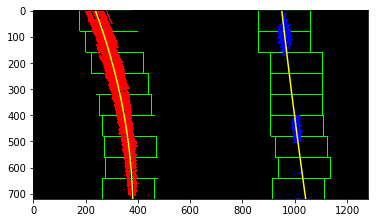

In [11]:
def detect_lane_pixels(image, display=False, margin = 100, minpix = 50):
    """
    image must be a binary image with a top-down view.
    display (True/False) is used when you want to plot the output.
    margin determines the width of the windows.
    minpix is the minimum number of pixels found to recenter the sliding window.
    """

    # Plotting a histogram to detect the x location of the lane lines.
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    if display:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return (ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty)


# Visualize results
%matplotlib inline

ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = detect_lane_pixels(binary_warped, display=True)

## Determine the curvature of the lane and vehicle position with respect to center.

I adapted the code provided in the example to fit my pipeline.

In [13]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_curvature(image, ploty, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix):
    """
    ym_per_pix - meters per pixel in y dimension
    xm_per_pix - meters per pixel in x dimension
    """
    
    # This designates the bottom row of the picture for the radius calculation
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    # I'll be using the minimum curve radius.
    curverad = np.min([left_curverad, right_curverad])
    
    return curverad

curverad = find_curvature(binary_warped, ploty, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix)

print(curverad, 'm')

689.513270991 m


## Find the position of the vehicle from the center of the lane

This implementation was adapted from the solution provided by the Q&A session.

In [14]:
def find_offset(image, left_fitx, right_fitx, xm_per_pix):
    camera_center = (left_fitx[-1] + right_fitx[1])/2
    center_diff = (camera_center - image.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    return (center_diff, side_pos)
        
center_diff, side_pos = find_offset(binary_warped, left_fitx, right_fitx, xm_per_pix)

## Warp the detected lane boundaries back onto the original image.

The below code cell was taken from the Q&A session on youtube and adapted to fit my pipeline.

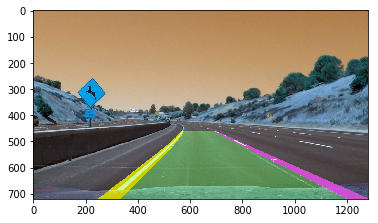

In [15]:
image = cv2.imread('./test_images/test2.jpg')
def warp_boundaries_to_original_image(image, ploty, left_fitx, right_fitx, src, dst, margin = 100):
    # Taking the margin used in the sliding window method to get the thickness of the lines.
    window_width = margin * 0.6
    # Variables to get: windows_width
    left_lane = np.array(list(zip(
        np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0))), np.int32)

    right_lane = np.array(list(zip(
        np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0))), np.int32)

    # This marks the horizontal boundaries of this polygon to be the left_lane and right_lane
    middle_marker = np.array(list(zip(
        np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0))), np.int32)

    road = np.zeros_like(image)
    road_bkg = np.zeros_like(image)
    middle = np.zeros_like(image)

    cv2.fillPoly(road, [left_lane], color=[255,255,0])
    cv2.fillPoly(road, [right_lane], color=[255,100,255])
    cv2.fillPoly(middle, [middle_marker], color=[50,255,50])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])

    # Just swapping the source and destination points previously used to undo the perspective transform.
    road_warped = warper(road, dst, src)
    road_warped_bkg = warper(road_bkg, dst, src)
    road_warped_middle = warper(middle, dst, src)

    base = cv2.addWeighted(image, 1.0, road_warped_bkg, -0.4, 0.0)
    lanes = cv2.addWeighted(base, 1.0, road_warped, 0.8, 0.0)
    result = cv2.addWeighted(lanes, 1.0, road_warped_middle, 0.3, 0.0)
    
    return result

result = warp_boundaries_to_original_image(image, ploty, left_fitx, right_fitx, src, dst)

plt.imshow(result)
plt.show()

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This was also adapted from the code in the Q&A session.

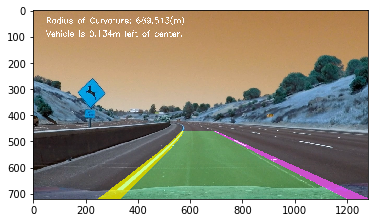

In [16]:
def add_annotations(image, center_diff, side_pos, curverad):

    # Add the vehicle position to the output image
    cv2.putText(image, 
                text = 'Vehicle is ' + str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center.',
                org = (50,100), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 1, 
                color = (255, 255, 255), 
                thickness = 2)

    # Add the radius of curvature to the output image
    cv2.putText(image, 
                text = 'Radius of Curvature: ' + str(round(curverad, 3)) + '(m)',
                org = (50,50), 
                fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 1, 
                color = (255, 255, 255), 
                thickness = 2)
    
    return image

plotted_result = add_annotations(result, center_diff, side_pos, curverad)


# Save the image to output_images for the writeup
cv2.imwrite('output_images/plotted_lane.jpg', plotted_result)

plt.imshow(plotted_result)
plt.show()

## Apply pipeline to video 
Also, I'll generate a video file.

In [ ]:
from moviepy.editor import VideoFileClip
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from binarythresholding import *

# Load calibration parameters
calibration = pickle.load(open( "camera_cal/calibration.p", "rb"))
mtx = calibration["mtx"]
dist = calibration["dist"]
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
margin = 100

# This function will apply to each frame.
def pipeline(image):
    # Undistort
    undistorted = cv2.undistort(image, mtx, dist)
    
    # Converted to Binary using thresholds
    binary = produce_thresholded_binary(undistorted)
    
    # Perspective Transform to bird's eye view
    binary_warped, src, dst = perspective_transform(binary)
    
    # Discern lane line pixels and fit polynomial to lane lines
    ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = detect_lane_pixels(binary_warped, display=True)
    
    # Find radius of curvature and position against center
    curverad = find_curvature(binary_warped, ploty, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix)
    center_diff, side_pos = find_offset(binary_warped, left_fitx, right_fitx, xm_per_pix)
    
    # Draw the lane lines and lane area onto the frame
    lanes_drawn_result = warp_boundaries_to_original_image(image, ploty, left_fitx, right_fitx, src, dst)
    
    # Draw the radius of curvature and position against center to the frame
    final_result = add_annotations(lanes_drawn_result, center_diff, side_pos, curverad)
    
    return final_result

# Names for the video files
Output_video = 'output_video.mp4'
Input_video = 'project_video.mp4'

# Open the video stream
clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(pipeline)
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

